## NHIS Recoding for the AllOfUs Coding Scheme

This notebook loads data from the 2018 National Health Interview Survey and recodes it according to the coding scheme in `src/coding_aou.py`.

Information on NHIS can be found here: https://www.cdc.gov/nchs/nhis/1997-2018.htm

In [1]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd

from collections import Counter

from src import pdf, plots, coding_aou as CODING

### User Parameters

In [2]:
# where the NHIS data files are stored
DATA_DIR = 'data'

# whether to drop all individuals less than 18 years old
ADULTS_ONLY = True

# recoded PUMS file, needed to filter recoded NHIS tuples to those actually occurring in the PUMS data
# (assumed to be located in the data directory)
PUMS_RECODED_FILENAME = 'pums_usa_2020_recoded_aou.csv'

# map of variable enum to column name in recoded pums file
PUMS_DATA = [
    # variable enum,              # recoded PUMS var name
    (CODING.Variables.AGE,        'Age'),          
    (CODING.Variables.RACE_ETH,   'RaceEth'),
    (CODING.Variables.INSURANCE,  'Insurance'),
    (CODING.Variables.EDUCATION,  'Education'),
    (CODING.Variables.INCOME,     'Income'),
    (CODING.Variables.SEX,        'Sex'),
]

# The NHIS data for consists of multiple files that need to be merged.
# There are identifiers for each household, family, and person to facilitate merging.
# An individual is uniquely identified by the combination of these three identifiers.

# Household identifier column: 'HHX'
# Family identifier column:    'FMX'
# Person identifier column:    'FPX'

PERSONS_FILENAME  = 'nhis_2018_personsx.csv'

# extract these cols from the PERSONS file
PERSONS_VARS = [
    'HHX',      # Household identifier
    'FMX',      # Family within the household identifier
    'FPX',      # Person within the family identifier
    'SEX',      # HHC.110_00.000 Sex of the person
    'AGE_P',    # HHC.420_00.000 Age of the person
    #'ORIGIN_I', # HHC.170_00.000 Hispanic ethnicity
    #'MRACBPI2', # HHC.200_01.000 Race coded to single/multiple race group
    'HISCODI3', # HHC.200_01.000 Race/Ethnicity recode
    'EDUC1',    # FSD.010_00.000 Highest level of school completed
    'COVER' ,   # FHI.070_00.000 Health insurance hierarchy under 65 (missing 12913) 
    'COVER65',  # FHI.070_00.000 Health insurance hierarchy over 65 (missing 59920)
    'WTFA',     # IDN.000_70.000 Weight - final annual
]

INCOME_FILENAME  = 'nhis_2018_incmimp1.dat'
# other NHIS data files not needed

# these columns identify the unique individuals
INDEX_COLS = ['HHX', 'FMX', 'FPX']

# whether to drop rows representing people NOT in the PUMS population
# (i.e. PUMS has no entries with missing insurance coverage, for instance)
MATCH_PUMS_CATEGORIES = True

#### Load the PUMS file

In [3]:
PUMS_FILE = os.path.join(DATA_DIR, PUMS_RECODED_FILENAME)
print('Loading file "{0}"...'.format(PUMS_FILE))
raw_df = pd.read_csv(PUMS_FILE)
# extract desired columns
keep_cols = [tup[1] for tup in PUMS_DATA]
pums_df = raw_df[keep_cols].copy()
pums_df

Loading file "data/pums_usa_2020_recoded_aou.csv"...


,Age,RaceEth,Insurance,Education,Income,Sex
0,5,0,0,0,3,1
1,5,0,0,0,2,1
2,0,0,0,0,0,0
3,0,0,1,2,0,0
4,0,4,0,1,0,1
...,...,...,...,...,...,...
2136799,2,3,1,1,2,1
2136800,2,0,0,0,1,1
2136801,2,0,0,0,1,0
2136802,0,0,0,2,2,0


#### Load the PERSONS file

In [4]:
persons_file = os.path.join(DATA_DIR, PERSONS_FILENAME)
raw_persons_df = pd.read_csv(persons_file)
raw_persons_df
# # extract desired columns and sort by identifier
persons_df = raw_persons_df[PERSONS_VARS]
persons_df.sort_values(by=INDEX_COLS, ascending=True)
persons_df

,HHX,FMX,FPX,SEX,AGE_P,HISCODI3,EDUC1,COVER,COVER65,WTFA
0,1,1,1,2,79,2,9,NaN,4.0,3539
1,4,1,1,2,55,2,14,1.0,NaN,5656
2,4,1,2,1,49,2,15,1.0,NaN,5848
3,4,1,3,1,16,2,10,1.0,NaN,5886
4,6,1,1,1,37,2,21,1.0,NaN,6009
...,...,...,...,...,...,...,...,...,...,...
72826,55557,1,1,2,49,3,5,4.0,NaN,7146
72827,55560,1,1,2,40,2,18,1.0,NaN,7902
72828,55562,1,1,2,61,2,18,1.0,NaN,7421
72829,55562,1,2,1,66,2,18,NaN,1.0,6485


#### Load the inputed income file

In [5]:
# The relevant fields are located at these character offsets:
# (see https://www.cdc.gov/nchs/data/nhis/incmimp_summary18.pdf)
#
#     HHX:      6-11
#     FMX:      12-13
#     FPX:      14-15
#     ERNYR_I2: 38-43 # person's total earnings in last year

hhx_data = []
fmx_data = []
fpx_data = []
inc_data = []
with open(os.path.join(DATA_DIR, INCOME_FILENAME), 'rt') as infile:
    for line in infile:
        if 0 == len(line):
            continue
        assert len(line) >= 34
        hhx = int(line[6:12])
        fmx = int(line[12:14])
        fpx = int(line[14:16])
        inc_str = line[38:44]
        if inc_str.isspace():
            # missing
            inc = math.nan
        else:
            inc = float(line[38:44])

        hhx_data.append(hhx)
        fmx_data.append(fmx)
        fpx_data.append(fpx)
        inc_data.append(inc)

# check some basic statistics to make sure the data was loaded correctly
# (see the final page of this document: https://www.cdc.gov/nchs/data/nhis/datdoc18.pdf)
inc_data = np.array(inc_data)
inc_check = inc_data[~np.isnan(inc_data)]
minval = np.min(inc_check)
maxval = np.max(inc_check)
meanval = np.mean(inc_check)
stdval = np.std(inc_check)

assert 37196 == len(inc_check)
assert 1 == minval
assert np.isclose(minval, [1])
assert np.isclose(maxval, [149000])
assert np.isclose(meanval, [48424.48])
# differs from value in the documentation: 39335.742
assert np.isclose(stdval, [39335.213])

"""
Recode the income values as follows:

    class Income(Enum):
        INC_LT_25   = 0  # less than $25K
        INC_25_50   = 1  # $25K to $49,999
        INC_50_100  = 2  # $50K to $99,999
        INC_GT_100  = 3  # $100K or more
        INC_MISSING = 4  # Missing 
"""

recoded_income = []
for inc in inc_data:
    if np.isnan(inc):
        # missing
        recoded_inc = CODING.Income.INC_MISSING.value
    else:
        if inc < 25000.0:
            recoded_inc = CODING.Income.INC_LT_25.value
        elif inc >= 25000.0 and inc < 50000.0:
            recoded_inc = CODING.Income.INC_25_50.value
        elif inc >= 50000.0 and inc < 100000.0:
            recoded_inc = CODING.Income.INC_50_100.value
        else:
            recoded_inc = CODING.Income.INC_GT_100.value
            
    recoded_income.append(recoded_inc)

income_data = {
    'HHX'    : hhx_data,
    'FMX'    : fmx_data,
    'FPX'    : fpx_data,
    'Income' : recoded_income,
}

income_df = pd.DataFrame(income_data)
income_df

,HHX,FMX,FPX,Income
0,1,1,1,4
1,4,1,1,4
2,4,1,2,1
3,4,1,3,4
4,6,1,1,3
...,...,...,...,...
72826,55557,1,1,4
72827,55560,1,1,0
72828,55562,1,1,2
72829,55562,1,2,2


#### Merge to create final dataframe

In [6]:
merged_df = pd.merge(persons_df, income_df, on=INDEX_COLS)
merged_df

,HHX,FMX,FPX,SEX,AGE_P,HISCODI3,EDUC1,COVER,COVER65,WTFA,Income
0,1,1,1,2,79,2,9,NaN,4.0,3539,4
1,4,1,1,2,55,2,14,1.0,NaN,5656,4
2,4,1,2,1,49,2,15,1.0,NaN,5848,1
3,4,1,3,1,16,2,10,1.0,NaN,5886,4
4,6,1,1,1,37,2,21,1.0,NaN,6009,3
...,...,...,...,...,...,...,...,...,...,...,...
72826,55557,1,1,2,49,3,5,4.0,NaN,7146,4
72827,55560,1,1,2,40,2,18,1.0,NaN,7902,0
72828,55562,1,1,2,61,2,18,1.0,NaN,7421,2
72829,55562,1,2,1,66,2,18,NaN,1.0,6485,2


In [7]:
# drop the identifier columns, no longer needed
nhis_df = merged_df.drop(columns=INDEX_COLS)
# sort cols in alphabetical order
nhis_df = nhis_df.sort_index(axis='columns')

if ADULTS_ONLY:
    nhis_df = nhis_df[nhis_df['AGE_P'] >= 18]
    nhis_df = nhis_df.reset_index(drop=True)

#### Dataframe prior to recoding

In [8]:
nhis_df

,AGE_P,COVER,COVER65,EDUC1,HISCODI3,Income,SEX,WTFA
0,79,NaN,4.0,9,2,4,2,3539
1,55,1.0,NaN,14,2,4,2,5656
2,49,1.0,NaN,15,2,1,1,5848
3,37,1.0,NaN,21,2,3,1,6009
4,36,1.0,NaN,18,2,3,2,5738
...,...,...,...,...,...,...,...,...
56160,49,4.0,NaN,5,3,4,2,7146
56161,40,1.0,NaN,18,2,0,2,7902
56162,61,1.0,NaN,18,2,2,2,7421
56163,66,NaN,1.0,18,2,2,1,6485


### Recode remaining variables

In [9]:
def sum_of_values(ctr):
    """
    Sum the values in the given instance of collections.Counter and return the total.
    """
    
    total = 0
    for k,v in ctr.items():
        total += v
    return total

In [10]:
# map of variable enumerator from the coding file to the name of that column
col_map = {
    # income column has already been recoded
    CODING.Variables.INCOME : 'Income'
}

#### Insurance

In [11]:
def recode_insurance(df):
    """
    Recode the insurance values as follows:
    
    class Insurance(Enum):
        YES     = 0  # Has health insurance
        NO      = 1  # Does not have health insurance
        MISSING = 2  # Missing
    """
    
    # neeed both the COVER and COVER65 variables, depending on age
    cover_vals = df['COVER'].values
    cover65_vals = df['COVER65'].values
    
    recoded_values = []
    for i, cover in enumerate(cover_vals):
        cover65 = cover65_vals[i]
        # one or both must be NaN, depending on age
        assert np.isnan(cover) or np.isnan(cover65)
        if np.isnan(cover) and np.isnan(cover65):
            # both are missing
            recoded = CODING.Insurance.MISSING.value
        else:
            # only one is valid (float type)
            if np.isnan(cover):
                assert not np.isnan(cover65)
                val65 = int(cover65)
                # for COVER65, values 1..5 mean yes, 6 == no, 7 == unknown (code as missing)
                if val65 >= 1 and val65 <= 5:
                    recoded = CODING.Insurance.YES.value
                elif 6 == val65:
                    recoded = CODING.Insurance.NO.value
                else:
                    assert 7 == val65
                    recoded = CODING.Insurance.MISSING.value
            else:
                assert not np.isnan(cover)
                val = int(cover)
                # for COVER, values 1..3 mean yes, 4 == no, 5 == unknown (code as missing)
                if val >= 1 and val <= 3:
                    recoded = CODING.Insurance.YES.value
                elif 4 == val:
                    recoded = CODING.Insurance.NO.value
                else:
                    assert 5 == val
                    recoded = CODING.Insurance.MISSING.value
                    
        recoded_values.append(recoded)
        
    # drop the COVER and COVER65 columns
    df = df.drop(columns=['COVER', 'COVER65'])
    # assign the recoded values to a new 'Insurance' column
    df = df.assign(Insurance = recoded_values)
    
    # check the recoded values
    ctr = Counter(df['Insurance'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.INSURANCE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [12]:
nhis_df = recode_insurance(nhis_df)
col_map[CODING.Variables.INSURANCE] = 'Insurance'

#### Education

In [13]:
def recode_education(df):
    """
    Recode the EDUC1 values as follows:
    
    class Education(Enum):
        COLLEGE_GRAD = 0  # College grad
        SOME_COLLEGE = 1  # Some college
        HS_GRAD      = 2  # High school graduate
        NOT_HS_GRAD  = 3  # Not a HS graduate
        MISSING      = 4  # Missing


    """
    
    values = df['EDUC1'].values
    
    recoded_values = []
    for val in values:
        if np.isnan(val):
            # missing
            recoded = CODING.Education.MISSING.value
        else:
            if val >= 16 and val <= 21:
                recoded = CODING.Education.COLLEGE_GRAD.value
            elif 15 == val:
                recoded = CODING.Education.SOME_COLLEGE.value
            elif 13 == val or 14 == val:
                recoded = CODING.Education.HS_GRAD.value
            elif val >= 0 and val <= 12:
                recoded = CODING.Education.NOT_HS_GRAD.value
            else:
                recoded = CODING.Education.MISSING.value
                
        recoded_values.append(recoded)
                
    # drop the EDUC1 column
    df = df.drop(columns=['EDUC1'])
    # assign recoded values to new column
    df = df.assign(Education = recoded_values)
    
    ctr = Counter(df['Education'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.EDUCATION]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [14]:
nhis_df = recode_education(nhis_df)
col_map[CODING.Variables.EDUCATION] = 'Education'

#### Race / Ethnicity

In [15]:
def recode_race_eth(df):
    """
    Recode the NHIS HISCODI3 values as follows:
    
    class Race(Enum):
        NH_WHITE = 0  # Non-Hispanic White only
        NH_BLACK = 1  # Non-Hispanic Black only 
        NH_ASIAN = 2  # Non-Hispanic Asian only
        HISPANIC = 3  # Hispanic
        OTHER    = 4  # Other
    """

    values = df['HISCODI3'].values
    
    recoded_values = []
    for nhis_race in values:
        assert nhis_race in {1,2,3,4,5}
        if 1 == nhis_race:
            # hispanic
            recoded = CODING.RaceEth.HISPANIC.value
        elif 2 == nhis_race:
            recoded = CODING.RaceEth.NH_WHITE.value
        elif 3 == nhis_race:
            recoded = CODING.RaceEth.NH_BLACK.value
        elif 4 == nhis_race:
            recoded = CODING.RaceEth.NH_ASIAN.value
        else:
            recoded = CODING.RaceEth.OTHER.value
            
        recoded_values.append(recoded)
        
    df = df.drop(columns=['HISCODI3'])
    df = df.assign(RaceEth = recoded_values)
    
    ctr = Counter(df['RaceEth'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.RACE_ETH]
    assert df.shape[0] == sum_of_values(ctr)
    return df    

In [16]:
nhis_df = recode_race_eth(nhis_df)
col_map[CODING.Variables.RACE_ETH] = 'RaceEth'

#### Recode sex

In [17]:
def recode_sex(df):
    """
    Recode the NHIS SEX values as follows:
    
    class Sex(Enum):
        MALE   = 0
        FEMALE = 1
        OTHER  = 2  (not in NHIS)
    """
    
    values = df['SEX'].values

    recoded_values = []
    for nhis_sex in values:
        assert nhis_sex in {1,2}
        if 1 == nhis_sex:
            recoded = CODING.Sex.MALE.value
        else:
            recoded = CODING.Sex.FEMALE.value
        recoded_values.append(recoded)
        
    df = df.drop(columns=['SEX'])
    df = df.assign(Sex = recoded_values)
    
    ctr = Counter(df['Sex'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.SEX]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [18]:
nhis_df = recode_sex(nhis_df)
col_map[CODING.Variables.SEX] = 'Sex'

#### Age

In [19]:
def recode_age(df):
    """
    Recode the NHIS AGE_P values as follows:
    
    class Age(Enum):
        AGE_18_29   = 0
        AGE_30_39   = 1
        AGE_40_49   = 2
        AGE_50_59   = 3
        AGE_60_69   = 4
        AGE_70_PLUS = 5
    """
    
    values = df['AGE_P'].values
    
    new_values = []
    for nhis_age in values:
        # the NHIS age should be in the range [0,85]
        assert nhis_age >= 0 and nhis_age <= 85
        
        if nhis_age >= 70:
            recoded = CODING.Age.AGE_70_PLUS.value
        elif nhis_age >= 60:
            recoded = CODING.Age.AGE_60_69.value
        elif nhis_age >= 50:
            recoded = CODING.Age.AGE_50_59.value
        elif nhis_age >= 40:
            recoded = CODING.Age.AGE_40_49.value
        elif nhis_age >= 30:
            recoded = CODING.Age.AGE_30_39.value
        else:
            recoded = CODING.Age.AGE_18_29.value
            
        new_values.append(recoded)
        
    df = df.drop(columns=['AGE_P'])
    df = df.assign(Age = new_values)
    
    ctr = Counter(df['Age'].values)
    assert min(ctr.keys()) >= 0
    assert max(ctr.keys()) < CODING.BIN_COUNTS[CODING.Variables.AGE]
    assert df.shape[0] == sum_of_values(ctr)
    return df

In [20]:
nhis_df = recode_age(nhis_df)
col_map[CODING.Variables.AGE] = 'Age'

#### Create final dataframe

In [21]:
# sort columns in alphabetical order
final_df = nhis_df.sort_index(axis=1)
final_df

,Age,Education,Income,Insurance,RaceEth,Sex,WTFA
0,5,3,4,0,0,1,3539
1,3,2,4,0,0,1,5656
2,2,1,1,0,0,0,5848
3,1,0,3,0,0,0,6009
4,1,0,3,0,0,1,5738
...,...,...,...,...,...,...,...
56160,2,3,4,1,1,1,7146
56161,2,0,0,0,0,1,7902
56162,4,0,2,0,0,1,7421
56163,4,0,2,0,0,0,6485


#### Plot the weighted and unweighted PDF of each variable

In [22]:
weighted_pdfs = {}
unweighted_pdfs = {}

# invert the column map to map column names to their variable enumerator
inv_col_map = {v:k for k,v in col_map.items()}

# ignore these cols for plotting PDFs
NON_DATA_COLS = {'WTFA'}

weights = final_df['WTFA'].values

# compute weighted PDF for each variable
for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    samples = final_df[col_name].values
    enumvar = inv_col_map[col_name]
    num_bins = CODING.BIN_COUNTS[enumvar]
    
    # weighted
    pdf_w = pdf.to_pdf(num_bins, samples, weights)
    weighted_pdfs[col_name] = pdf_w
    
    # unweighted
    pdf_u = pdf.to_pdf(num_bins, samples)
    unweighted_pdfs[col_name] = pdf_u

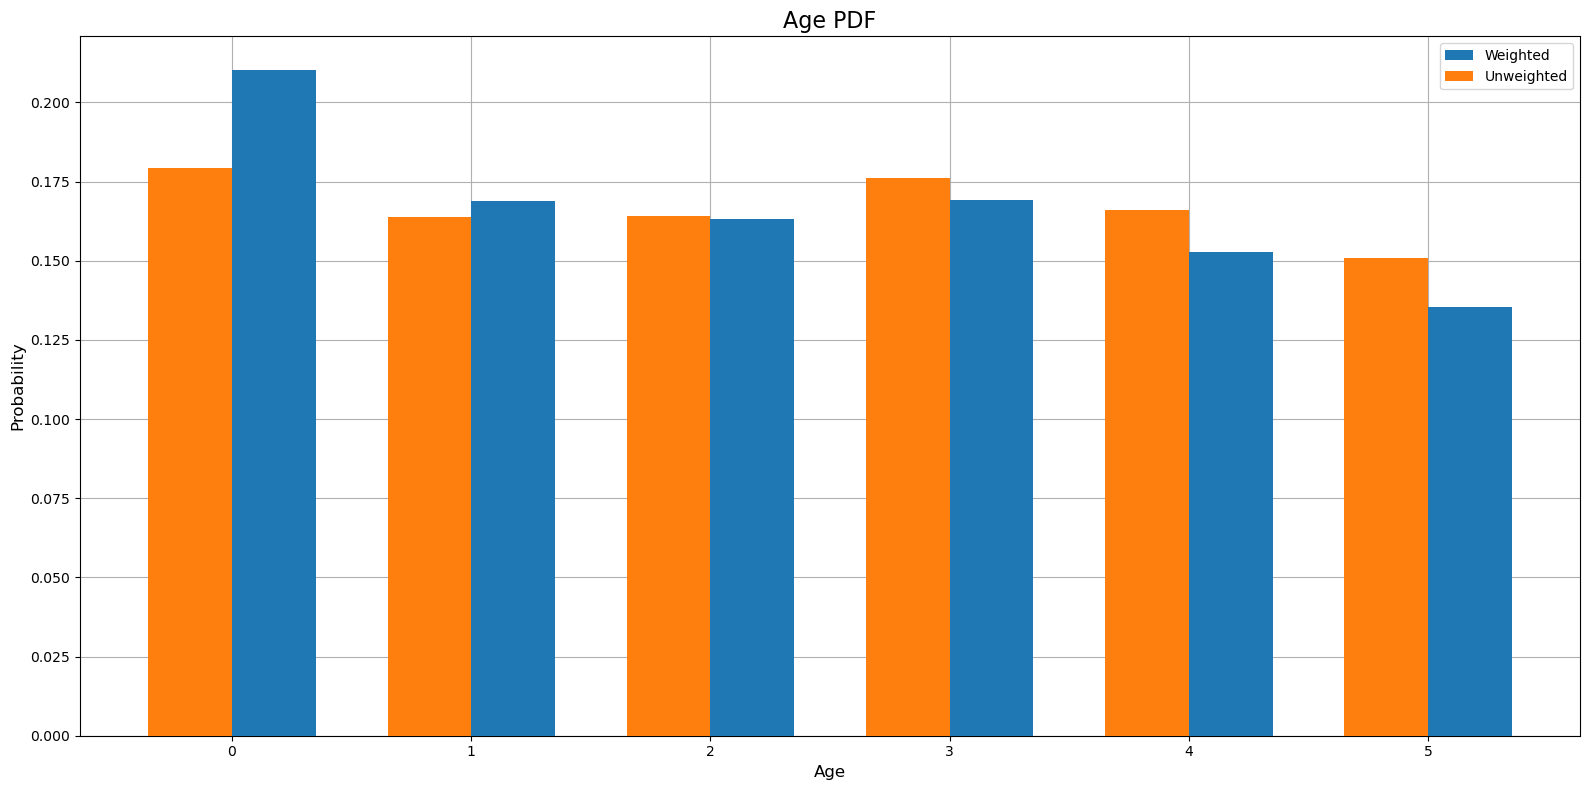

Unweighted PDF : [0.179 0.164 0.164 0.176 0.166 0.151]
  Weighted PDF : [0.21  0.169 0.163 0.169 0.153 0.135]


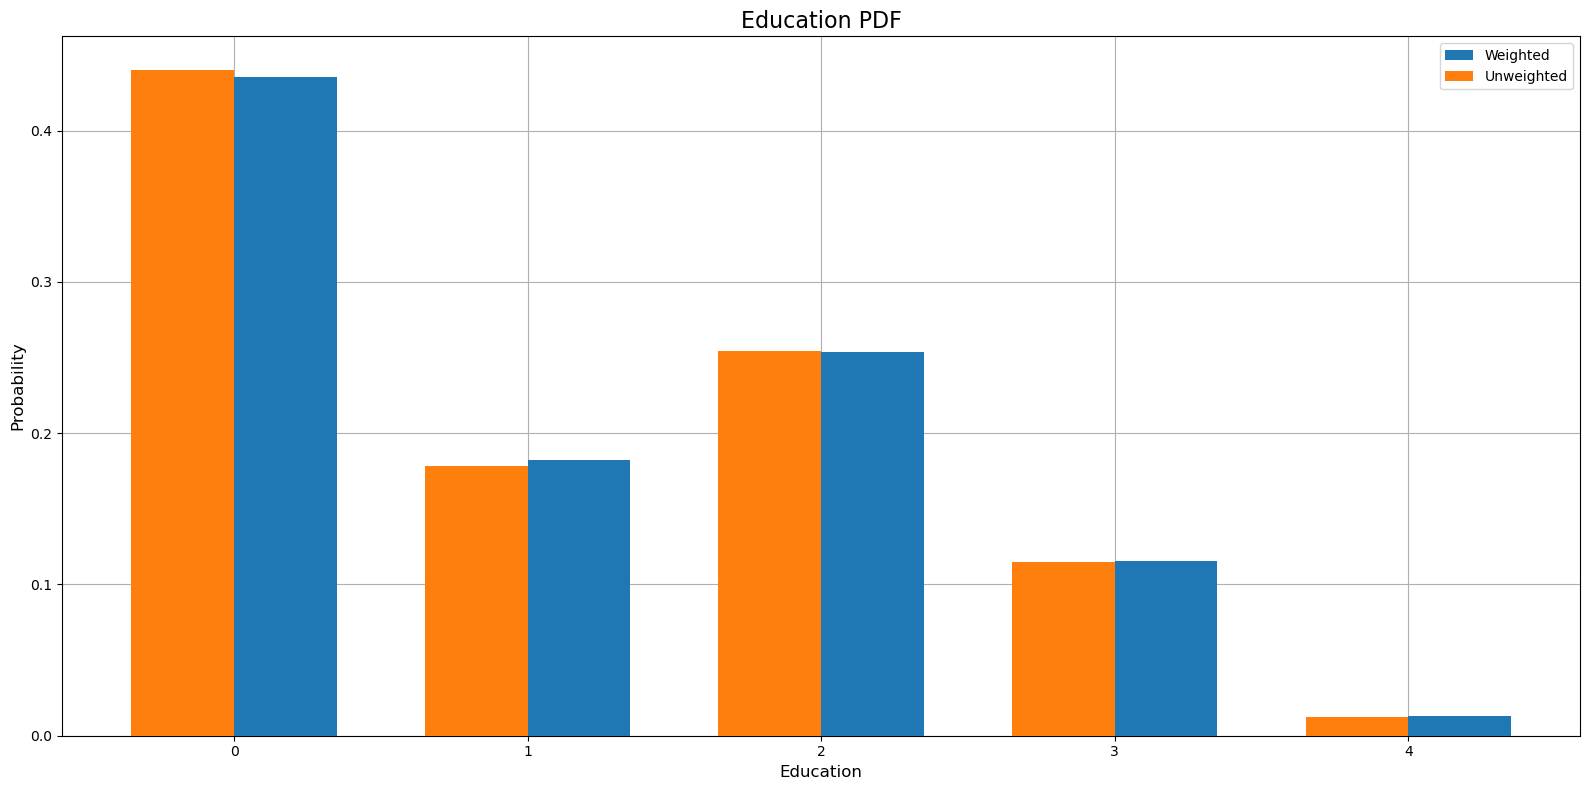

Unweighted PDF : [0.44  0.178 0.254 0.115 0.013]
  Weighted PDF : [0.436 0.182 0.254 0.116 0.013]


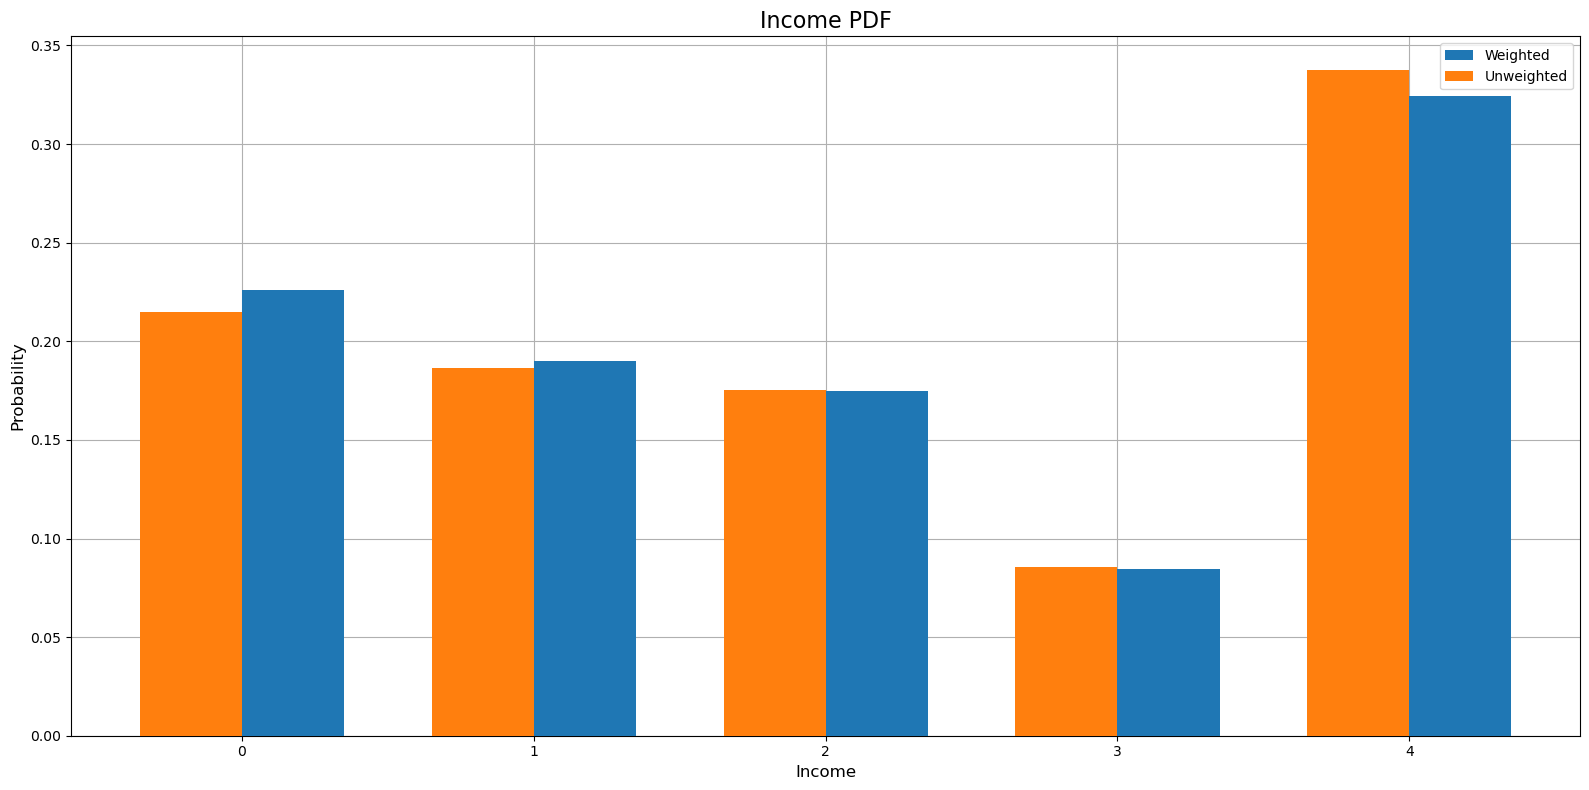

Unweighted PDF : [0.215 0.186 0.175 0.085 0.338]
  Weighted PDF : [0.226 0.19  0.175 0.085 0.325]


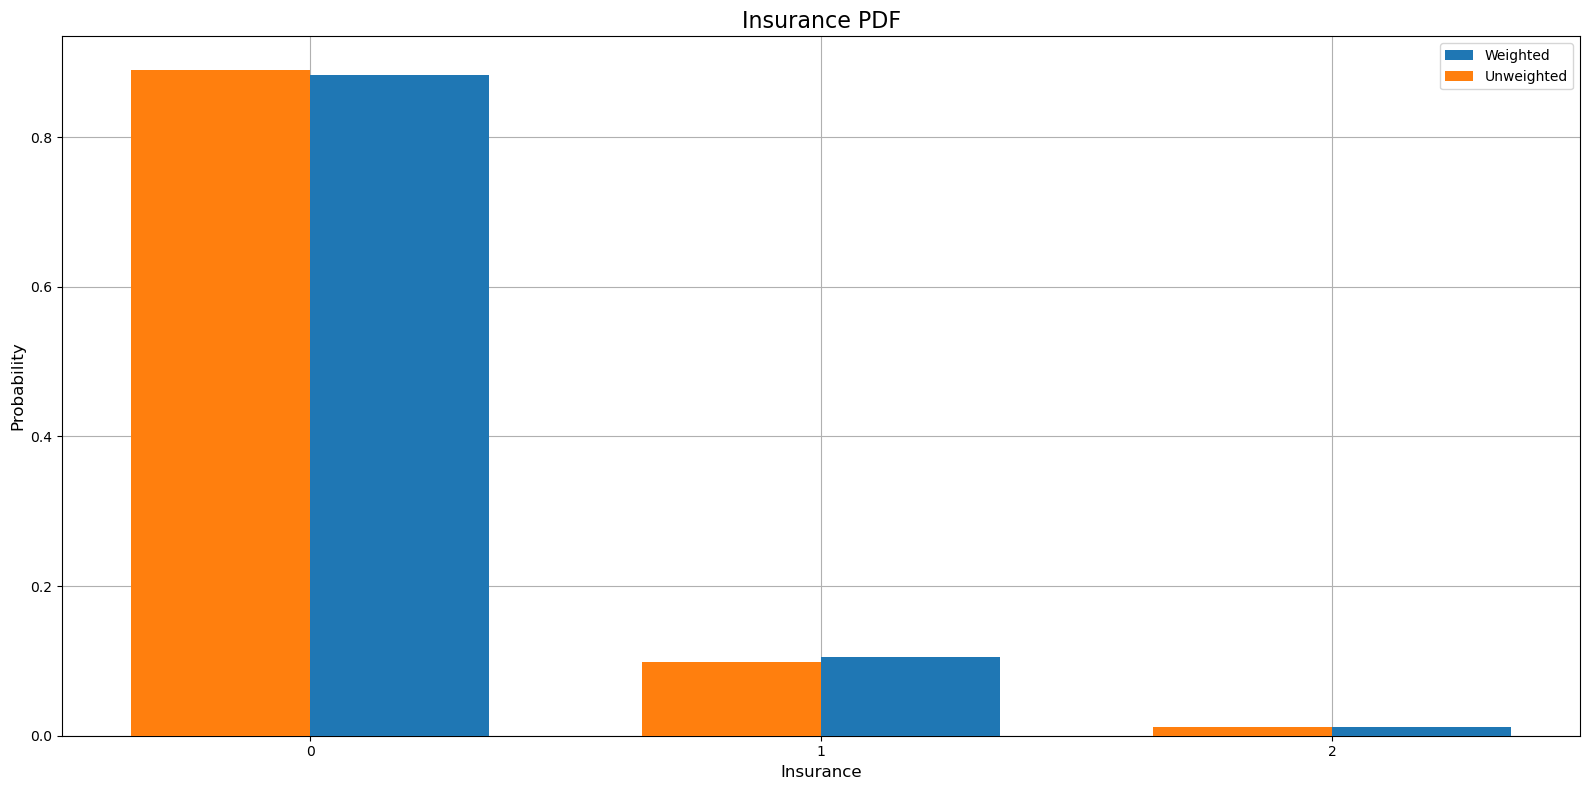

Unweighted PDF : [0.89  0.098 0.011]
  Weighted PDF : [0.883 0.105 0.012]


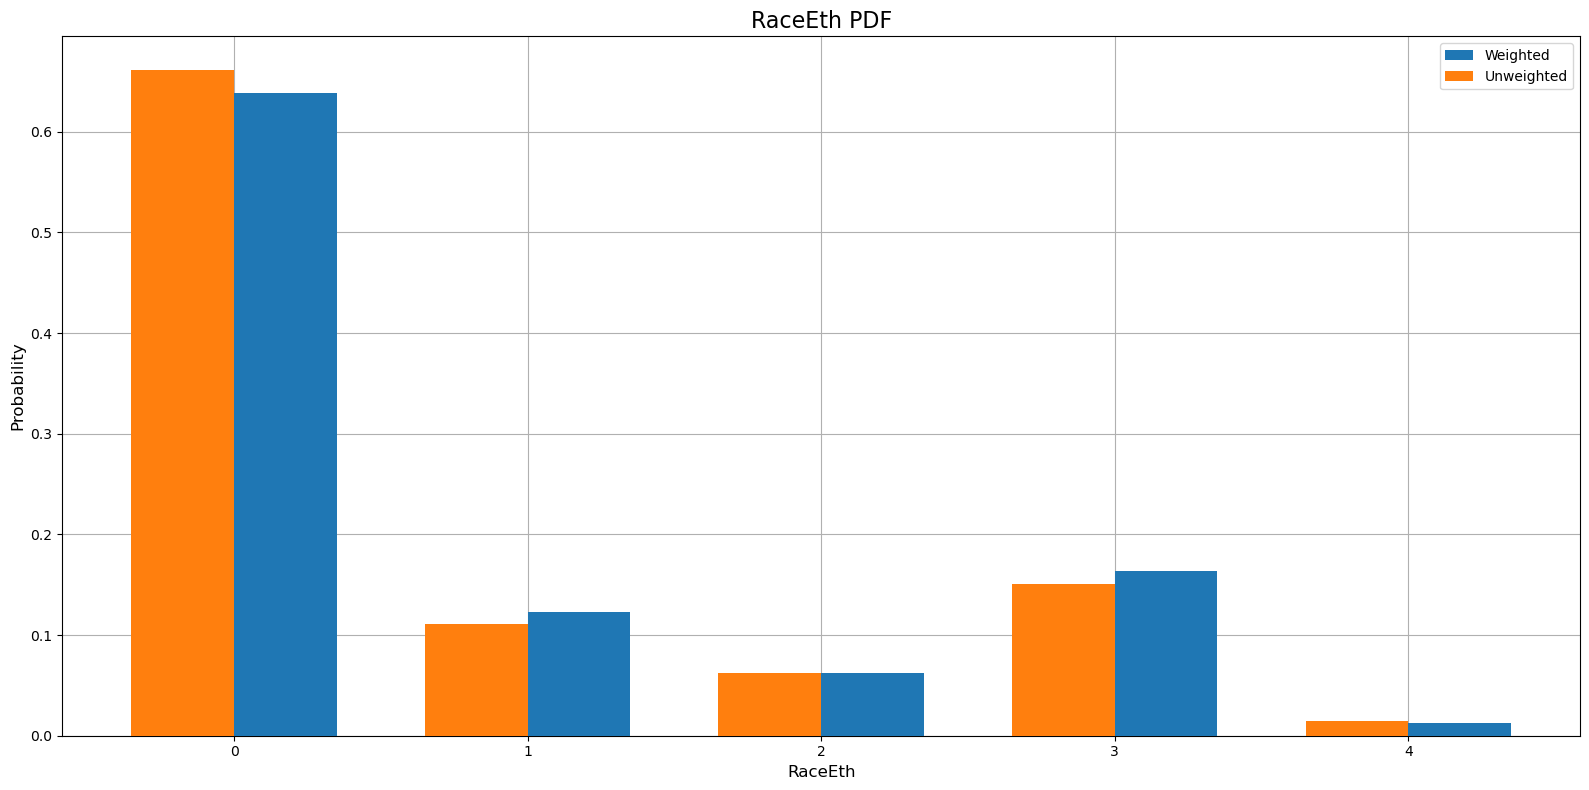

Unweighted PDF : [0.662 0.111 0.062 0.15  0.015]
  Weighted PDF : [0.638 0.123 0.063 0.163 0.013]


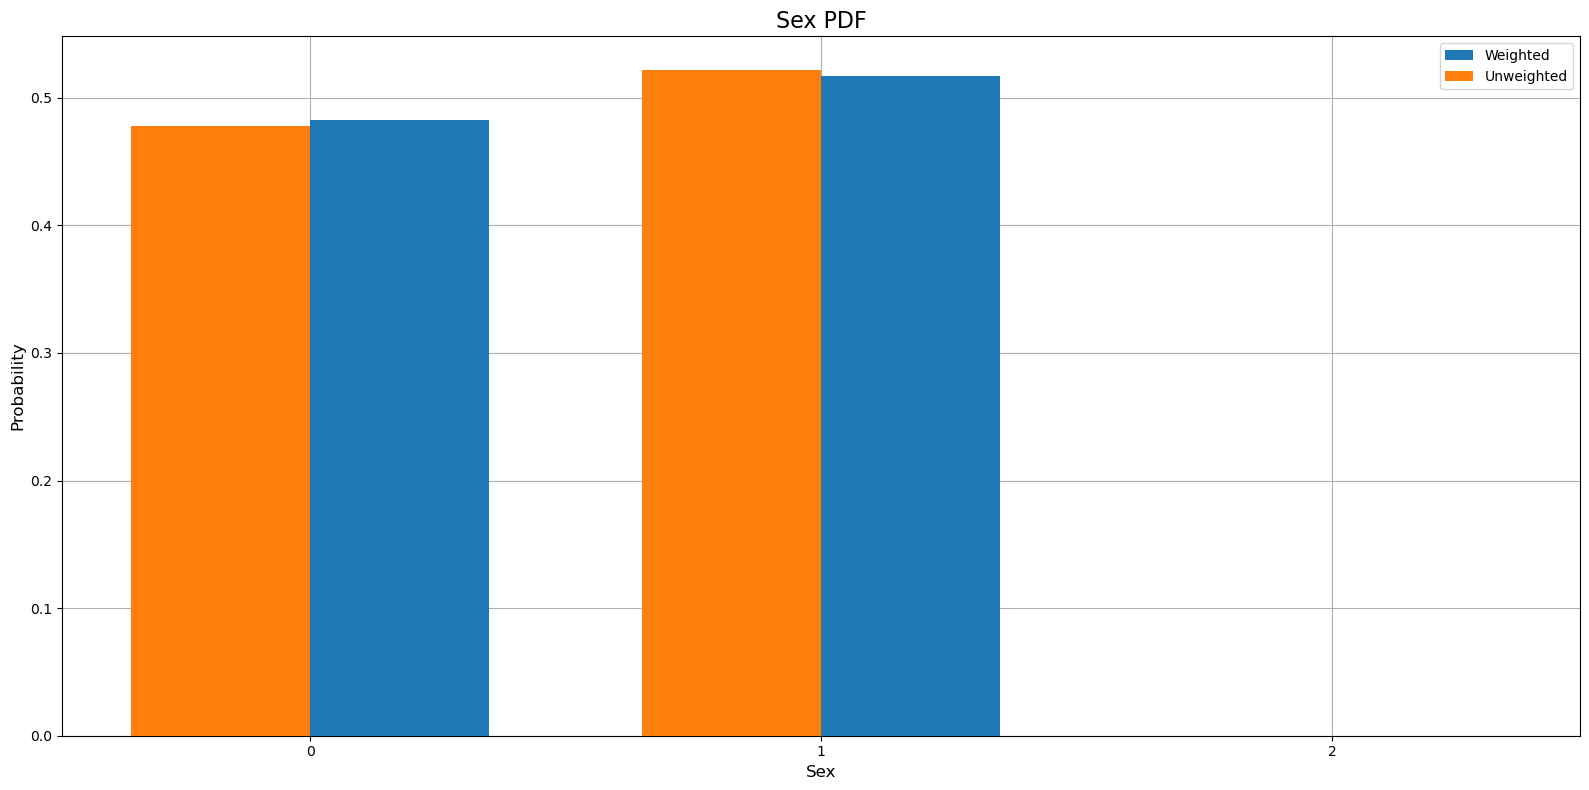

Unweighted PDF : [0.478 0.522 0.   ]
  Weighted PDF : [0.483 0.517 0.   ]


In [23]:
# display precision
P = 3

for col_name in final_df.columns:
    if col_name in NON_DATA_COLS:
        continue
        
    plots.dual_histogram_from_pdfs(col_name, unweighted_pdfs[col_name], weighted_pdfs[col_name],
                                   labels=['Unweighted', 'Weighted'])
    
    print('Unweighted PDF : {0}'.format(np.array_str(unweighted_pdfs[col_name], precision=P)))
    print('  Weighted PDF : {0}'.format(np.array_str(weighted_pdfs[col_name],   precision=P)))

#### Find recoded NHIS tuples occurring in the recoded PUMS data

These are the only tuples that could have been obtained by sampling the PUMS population. More categories for each variable will result in fewer combinations that actually occur in the PUMS data.

In [24]:
# # convert the PUMS data to tuples
# pums_tuples = set(pums_df.itertuples(index=False, name=None))
# print('There are {0} unique tuples in the PUMS data.'.format(len(pums_tuples)))

# # drop the weight column from the NHIS data and convert it to tuples
# nhis_no_wt_df = final_df.drop(columns=['WTFA'])
# nhis_tuples = set(nhis_no_wt_df.itertuples(index=False, name=None))
# print('There are {0} unique tuples in the NHIS data.'.format(len(nhis_tuples)))

# common_tuples = pums_tuples.intersection(nhis_tuples)
# print('Found {0} tuples in common.'.format(len(common_tuples)))

In [25]:
# keep_indices = []
# for indexed_tup in nhis_no_wt_df.itertuples(index=True, name=None):
#     index = indexed_tup[0]
#     tup = indexed_tup[1:]
#     assert tup in nhis_tuples
#     if tup in pums_tuples:
#         keep_indices.append(index)

# nhis_final_df = nhis_df.iloc[keep_indices]
# final_df = nhis_final_df.reset_index(drop=True)
# final_df

#### Write final dataframe to disk

In [26]:
# extract nhis_yyyy from the persons file
prefix = PERSONS_FILENAME[:len('nhis_yyyy')]
output_file = os.path.join(DATA_DIR, prefix + '_recoded_aou' + '.csv')
final_df.to_csv(output_file, index=False)
print('Wrote file "{0}".'.format(output_file))

Wrote file "data/nhis_2018_recoded_aou.csv".
